# Sparkify

## Table of Contents
1. [Overview](#overview)
2. [Load and Clean Dataset](#preprocess)
    1. [Import necessary packages](#package)
    2. [Preprocessing walkthrough](#walkthrough)
3. [Exploratory Data Analysis](#eda)
    1. [Define churn](#churn)
    2. [Explore data](#exdata)
4. [Feature Engineering](#feature_eng)
5. [Modeling](#modeling)
    1. [Metrics](#metrics)
    2. [Baseline Model](#baseline)
    3. [Logistic Regression](#lr)
    4. [Gradient Boosted Trees](#gbt)
    5. [Support Vector Machine](#svm)
    6. [Random Forest](#rf)
    7. [Model Summary](#model_summary)
    8. [Hyper Params Tuning](#tuning)
    9. [Best Model](#best_model)
    10. [Best Model Metrics](#final_metrics)
    11. [Feature Importance from GBTClassifier](#importance)
6. [Conclusion](#conclusion)
    1. [Summary](#conclusion)
    2. [Reflection](#conclusion)
    3. [Improvement](#conclusion)

## Overview <a id='overview'></a>
Sparkify is a music streaming service just as Spotify and Pandora. 

The data provided is the user log of the service, having demographic info, user activities, timestamps and etc. We try to analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning. 

We use F1 score to measure of model performance because we need precision and recall at the same time as we don't want to miss too many customers who are likely to churn whilst we don't want to waste too much on those who are not likely to churn. 

We performed EDA to establish features, and train several machine learning classification models.

The model we built and selected has a F1 score of 0.800, which is 16% higher than sending everybody offers. There is also a short article about this project posted here.

**The problem that I will attempt to solve will be to predict customer churn in advance and I will be using spark (PySpark) and the Gradient boosting models classification.**

## Load and Clean Dataset <a id='preprocess'></a>
In this workspace, the filename is `medium-sparkify-event-data.json`.

* The chunk below is the starter code for using IBM-Watson cloud. I've already anonymized the credentials and config. IBM-Watson cloud will automatically generate this chunk of code once you upload your data from local.

In [ ]:
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'some_url',
    'api_key': 'you_api_key',
    'service_id': 'your_service_id',
    'iam_service_endpoint': 'your_token'}

configuration_name = 'os_a68347975ac949879ccd31e5ca85693c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'your_project_name'))
df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190117233955-0001
KERNEL_ID = 2869154d-fb47-45ed-8bb8-8da2d9d2bafc


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

### Import necessary packages <a id='package'></a>

In [1]:
# import pyspark related libraries
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import pandas, matplotlib, and seaborn for visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime for parsing datetime object
import datetime

from time import time

### Preprocessing walk through <a id='walkthrough'></a>
1. Load the data from json file.
2. Delete NAs.
3. Remove rows with empty as `UserId`.
4. Convert `gender` column to binary numeric column.
5. Convert `ts` and `registration` columns to human readable time stamp format.
6. Create `churn` column, 1 representing user has churned, 0 otherwise. If event `Cancellation Confirmation` observed, we assume the user has churned.

First, we clean our dataset, checking for invalid or missing data. For example, records without userids or sessionids. 

In [ ]:
# drop NAs
df_valid = df_data_1.dropna(how = 'any', subset = ['userId', 'sessionId'])

After dropping missing values, we found that missing userId is actually represented by an empty string as shown below. A record with empty userId is probably generated when the user didn't log in or havn't signed up yet, and it contributes little to our analysis afterwards. Therefore, we drop these rows with empty string as userId. 

In [ ]:
# inspect 'userId' column
df_valid.select('userId').dropDuplicates().sort('userId').show(5)
# drop empty strings
df_valid = df_valid.filter(df_valid['userId'] != '')

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



## Exploratory Data Analysis <a id='eda'></a>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

A glimpse of the data when are about to deal with.

In [ ]:
df_valid_pd = df_valid.toPandas()
df_valid_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


### Define Churn <a id='churn'></a>

We defined a user as `churned` when there's an event called `Cancellation Confirmation` appeared in activity log. This event happens for both paid and free users, meaning that their account associated with us was terminated at the time. When also kept in track of a downgrade event, labeled as `Submit Downgrade` in activity log.

In [ ]:
# create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_valid = df_valid.withColumn("downgrade_event", flag_downgrade_event("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')
df_valid = df_valid.withColumn('downgrade', max('downgrade_event').over(windowval))

# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_valid = df_valid.withColumn('churn_event', flag_churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_valid = df_valid.withColumn('churn', max('churn_event').over(windowval))

In [ ]:
df_valid.select(['userId', 'churn', 'downgrade']).dropDuplicates().show(20)

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    1|        0|
|200002|    1|        0|
|   296|    1|        0|
|   125|    0|        0|
|   124|    1|        0|
|    51|    1|        0|
|     7|    0|        0|
|200037|    1|        0|
|   169|    0|        0|
|   205|    0|        0|
|   272|    0|        0|
|    15|    0|        0|
|   232|    0|        1|
|   234|    1|        0|
|   282|    0|        0|
|    54|    1|        0|
|   155|    0|        0|
|200043|    0|        0|
|100014|    1|        0|
|   132|    1|        0|
+------+-----+---------+
only showing top 20 rows



As shown in the table above, the time stamp columns aren't quite intuitive for human to read, so we put a little effort to convert these columns to a more human readable format.

In [ ]:
# add a time column to df
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid = df_valid.withColumn('event_time', convert_ts('ts'))
df_valid = df_valid.withColumn('registration_time', convert_ts('registration'))

### Explore Data <a id='exdata'></a>

#### Unique activities

In [ ]:
df_valid.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



There are mainly 19 activities that a user may have.

#### Customer lifetime statistics

In [ ]:
lifetime_pd = df_valid.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime_pd = lifetime_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


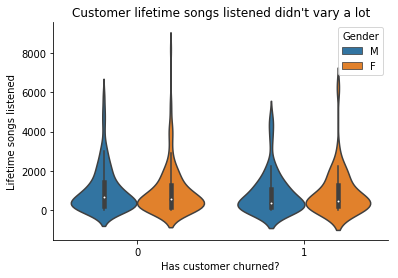

In [ ]:
ax = sns.violinplot(data=lifetime_pd, x='churn', y='NextSong', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs listened didn\'t vary a lot')
sns.despine(ax=ax);

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


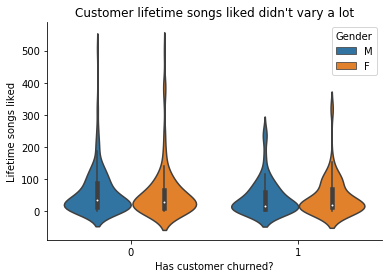

In [ ]:
ax = sns.violinplot(data=lifetime_pd, x='churn', y='Thumbs Up', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs liked')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs liked didn\'t vary a lot')
sns.despine(ax=ax);

#### Churn pattern between genders

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


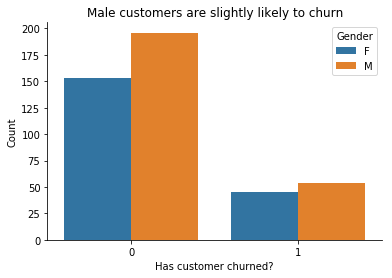

In [ ]:
gender_churn_pd = df_valid.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

ax = sns.barplot(x='churn', y='count', hue='gender', data=gender_churn_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Male customers are slightly likely to churn')
sns.despine(ax=ax);

#### Number of songs played per session

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:942: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


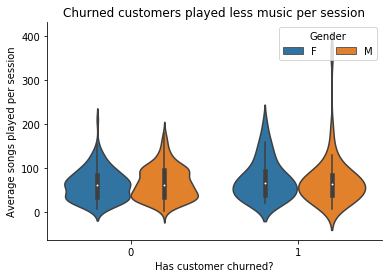

In [ ]:
songs_gender_pd = df_valid.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_gender_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('Churned customers played less music per session')
sns.despine(ax=ax);

#### At which level do customers churn

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


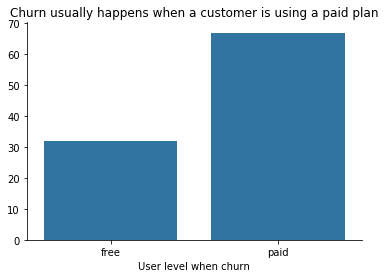

In [ ]:
level_pd = df_valid.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

ax = sns.barplot(data=level_pd, x='level', y='count', color=sns.color_palette()[0])
plt.xlabel('User level when churn')
plt.ylabel('')
plt.title('Churn usually happens when a customer is using a paid plan')
sns.despine(ax=ax);

#### Time since registration

In [36]:
lt_pd = df_valid \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


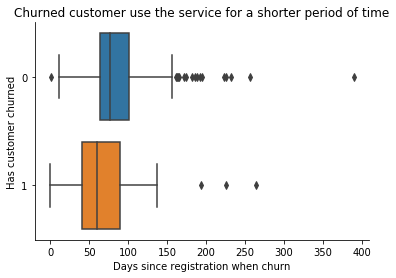

In [43]:
ax = sns.boxplot(data=lt_pd, y='churn', x='lifetime', orient='h')
plt.xlabel('Days since registration when churn')
plt.ylabel('Has customer churned')
plt.title('Churned customer use the service for a shorter period of time')
sns.despine(ax=ax);

## Feature Engineering <a id='feature_eng'></a>
We've familiarized ourselves with the data, we begin to build out the features we find promising to train your model on. 

* The first feature we considered is the time length since the user registered. It may reflect the user engagement, loyality, and etc.

In [18]:
# Time since registration
f1 = df_valid \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df_valid.ts-df_valid.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
f1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571|  82.83222149884257|
| stddev|105964.58428485187|  40.54572803476974|
|    min|                10|-0.5227314814814815|
|    max|                99|  390.3197569444444|
+-------+------------------+-------------------+



* The second feature we considered is the total number of songs listened. The more songs the user listened, the more time the user spent with our service, the deeper engagement the user have, leading to less chance to churn.

In [19]:
# Total songs listened
f2 = df_valid \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
f2.describe().show()

+-------+-----------------+------------------+
|summary|           userID|       total_songs|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|1178.5825892857142|
| stddev|105964.5842848519| 1380.627964752405|
|    min|               10|                 3|
|    max|               99|              9767|
+-------+-----------------+------------------+



* The third and fourth features are number of thumbs up and down. They may reflect two perspectives, our service quality and user engagement.

In [20]:
# Number of Thumbs-Up/Down
f3 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
f3.describe().show()
f4 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
f4.describe().show()

+-------+-----------------+-----------------+
|summary|           userID|     num_thumb_up|
+-------+-----------------+-----------------+
|  count|              439|              439|
|   mean|67308.81548974942|54.27334851936219|
| stddev|106228.8040825479|69.94135178778983|
|    min|               10|                1|
|    max|               99|              506|
+-------+-----------------+-----------------+

+-------+-----------------+------------------+
|summary|           userID|    num_thumb_down|
+-------+-----------------+------------------+
|  count|              389|               389|
|   mean|70031.19537275065|12.624678663239074|
| stddev|106895.7373531136|13.582432851937993|
|    min|               10|                 1|
|    max|               99|                80|
+-------+-----------------+------------------+



* The fifth feature is the number of songs added to the playlist, and it functioned as about the same as the 3rd and 4th feature.

In [21]:
# Number of songs added to playlist
f5 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')
f5.describe().show()

+-------+------------------+------------------+
|summary|            userID|   add_to_playlist|
+-------+------------------+------------------+
|  count|               428|               428|
|   mean| 65764.93457943926|28.852803738317757|
| stddev|105363.38578382804|  33.9130906945663|
|    min|                10|                 1|
|    max|                99|               248|
+-------+------------------+------------------+



* The sixth feature is the number of friends added.

In [22]:
# Number of friends added
f6 = df_valid \
    .select('userID','page') \
    .where(df_valid.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend') 
f6.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               409|               409|
|   mean|  66368.3716381418|19.772616136919314|
| stddev|106064.01609030597|22.494435766272833|
|    min|                10|                 1|
|    max|                99|               158|
+-------+------------------+------------------+



* The seventh feature is the length of listening, serving the same objective as the total number of songs listened, but in a time perspective.

In [23]:
# Total length of listening
f7 = df_valid \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
f7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571| 240270.4976090624|
| stddev|105964.58428485188|286257.95260453084|
|    min|                10|         131.00363|
|    max|                99| 2019435.103940004|
+-------+------------------+------------------+



* The eighth feature is the average number of songs listened per session

In [24]:
# Number of songs listened per session
f8 = df_valid.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
f8.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|65.61168409976808|
| stddev|105964.58428485187|39.49496566617269|
|    min|                10|              1.0|
|    max|                99|            360.0|
+-------+------------------+-----------------+



* The ninth feature is the gender, as we want to include some demographic information about the user, and there are differences between genders in terms of chance to churn.

In [25]:
# Gender
f9 = df_valid \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
f9.describe().show()

+-------+------------------+------------------+
|summary|            userId|            gender|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.4419642857142857|
| stddev|105964.58428485187|0.4971756279079039|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



* The tenth feature is the number of artists listened. 

In [26]:
# Number of artists listened
f10 = df_valid \
    .filter(df_valid.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
f10.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|658.9799107142857|
| stddev|105964.58428485188|625.8826980519568|
|    min|                10|                1|
|    max|                99|             3507|
+-------+------------------+-----------------+



* At last, we have the churn label

In [27]:
# Churn label
label = df_valid \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              label|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571|0.22098214285714285|
| stddev|105964.58428485187| 0.4153723104396361|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



Then we merge all features and label together.

In [56]:
# Construct 
data = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .join(f8,'userID','outer') \
    .join(f9,'userID','outer') \
    .join(f10,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|       listen_time|  avg_songs_played|gender|artist_count|label|
+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|14.328449074074074|        137|           4|             3|              1|         3|25870.950739999997|              48.0|     1|          94|    1|
| 53.32314814814814|        395|          15|             5|              6|         2| 78695.82683999998|              62.0|     0|         287|    1|
| 26.63826388888889|        152|           8|             0|              3|         2|28314.150059999996|              22.4|     1|         108|    1|
|105.42211805555554|         84|           3|             1|              2|         3|1

## Modeling <a id='modeling'></a>

### Metrics <a id='metrics'></a>
We select F-1 score as our evaluation metrics. The reason we use F-1 score here is because it gives us a simple measure of the precision (whether we send offer to the right person) and recall (whether we miss one that we should’ve sent the offer) of the model. We want to identify those who are likely to churn and give them some special offers in trying to keep the customer, but at the same time, we do not want to send too many offers (most likely a monetary incentive) to those who are not as likely to churn and therefore wasting money and resources.

First we need to vectorize our features.

In [57]:
# Vector assembler
cols = ["lifetime", "total_songs", "num_thumb_up", \
          'num_thumb_down','add_to_playlist','add_friend','listen_time','avg_songs_played', \
        'gender', 'artist_count']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

In order to avoid one feature with larger scale dominant the whole model, we standardize the features by taking off the mean and divided by the standard deviation of each feature.

In [58]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

Then we split the data into train, validation, and test sets by calling `randomSplit` method twice. We can also conduct a stratified sampling as our label is pretty skewed.

In [59]:
# train test split
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

#### Baseline Model <a id='baseline'></a>

We evaluate two baseline models, one with all users labelled as `churn = 1`, one with all users labelled as `churn = 0`. And we calculated the model accuracy and f1 score.

In [66]:
results_base_all_1 = test.withColumn('prediction', lit(1.0))

In [67]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.20833333333333334
F-1 Score:0.07183908045977012


In [68]:
results_base_all_0 = test.withColumn('prediction', lit(0.0))

In [69]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.7916666666666666
F-1 Score:0.6996124031007752


As we can see, the baseline model of labelling all users with `churn = 0` actually does a descent job on test set, with accuracy of 79.2% and f1 score of 0.6996.

Then we evaluate four different models, using cross validation to minimize the chance of overfitting, and grid search to tune our model. After evaluating the four models on validation set, we pick the best one based on the f1 score on that and train the best model on training set again then to evaluate on test set.

#### Logistic Regression <a id='lr'></a>

In [50]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [51]:
start = time()
cvModel_lr = crossval_lr.fit(train)
end = time()
cvModel_lr.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 1047.4673156738281 seconds


In [52]:
results_lr = cvModel_lr.transform(validation)

In [53]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.7346938775510204
F-1 Score:0.6223289315726291


#### Gradient Boosted Trees <a id='gbt'></a>

In [54]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [55]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
cvModel_gbt.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 1560.4856595993042 seconds


In [56]:
results_gbt = cvModel_gbt.transform(validation)

In [57]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.7755102040816326
F-1 Score:0.7560738581146744


#### Support Vector Machine <a id='svm'></a>

In [58]:
# initialize classifier
svm = LinearSVC(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [59]:
start = time()
cvModel_svm = crossval_svm.fit(train)
end = time()
cvModel_svm.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 1183.9568738937378 seconds


In [60]:
results_svm = cvModel_svm.transform(validation)

In [61]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.7346938775510204
F-1 Score:0.6223289315726291


#### Random Forest <a id='rf'></a>

In [62]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [63]:
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
cvModel_rf.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 1220.6458237171173 seconds


In [64]:
results_rf = cvModel_rf.transform(validation)

In [65]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.7755102040816326
F-1 Score:0.708073108761577


#### Model summary: <a id='model_summary'></a>
* The logistic regression model has a accuracy of: 0.735, and F1 score of:0.622, using 1047.5 seconds on our server.
* The gradient boosted trees model has a accuracy of: 0.776, and F1 score of: 0.756, using 1560.5 seconds on our server.
* The support vector machine model has a accuracy of: 0.735, and F1 score of: 0.622, using 1184.0 seconds on our server.
* The random forest model has a accuracy of: 0.776, and F1 score of: 0.708, using 1220.6 seconds on our server.



Although we do care about time resources, but since the data size is still reletively small, and the performance difference is huge, we will prefer the model that perform the best. Therefore, we choose GBT model as our final used model and conduct a grid search to fine tune our model this time. 

In the future, we may instead implement random forest model for more time efficiency.

#### Hyperparams tunning <a id='tuning'></a>

We use grid search to fine tune our GBT Classifier. We mainly tuned two parameters, `maxDepth` and `maxIter`.

In [68]:
GBTClassifier(maxIter=10,seed=42)

# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.maxIter, [10,15]) \
    .build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [69]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.7585510165523377, 0.739135085153991, 0.7027674008900453, 0.7027674008900453]

#### Best model <a id='best_model'></a>

In [60]:
gbt_best = GBTClassifier(maxIter=10,seed=42, maxDepth=5)
gbt_best_model = gbt_best.fit(train)
results_final = gbt_best_model.transform(test)

#### Final result metrics <a id='final_metrics'></a>

In [48]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.8083333333333333
F-1 Score:0.8001424501424502


#### Feature Importance from GBT model <a id='importance'></a>

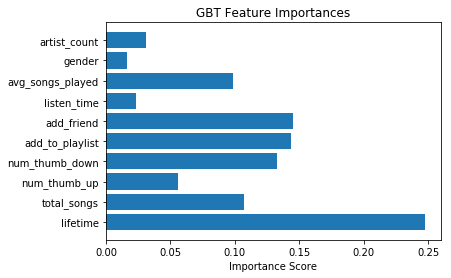

In [49]:
feat_imp = gbt_best_model.featureImportances.values
cols = ["lifetime", "total_songs", "num_thumb_up", \
          'num_thumb_down','add_to_playlist','add_friend','listen_time','avg_songs_played', \
        'gender', 'artist_count']
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

We utilized the feature importance attribute of the Gradient Boosted Tree model. From the chart, we can see length of using the service actually plays a very important role. But this may be biased by the fact that those who churned definitely had shorter period of time using the service, and thus, we may re-consider our model or do some transformation to reduce the bias. Other than that, number of thumbs down, number of friend added and number of songs added to the playlist also play important role. For example, large number of thumbs down may indicate that our service cannot correctly recommend songs to user; large number of songs added may indicate that the user loves the song provided by our service, etc.

## Conclusion <a id='conclusion'></a>

### Summary
In this notebook, we implemented a model trying to predict customer churn. We removed rows with no userId, converted timestamp to a human readable format, converted gender to binary numeric column. 10 features were built for our model. We selected 4 models: logistic regression, GBM, SVM, and RF to compare and select GBM as the final model implemented for predicting final result. We used cross validation and grid search to fine tune our model. We achieved about 80% accuracy, and 0.81 F1 score, which is about 15% improvement compare to our baseline model - sending everyone an offer.

### Reflection
This project gives exposure to spark environment to analyze a large volume of data that a personal laptop may not be capable to analyze. By identifying customer with high chance to churn prior to the acutal losing, companies are able to use minimal cost to save customers by using targeted messages and offers. 

One of the interesting yet difficult things during the project is brainstroming the features that we can derived from the data we have on hand. Developing useful features is crucial to developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis play important role in this process.

### Improvement
The features can be improved a lot after considering more factors, adding more domain knowledges and expertise. Although the volume of data may required tools such as spark to analyze, but we can use more data to have better results as the user base grow.

Currently, we have about 450 records of unique users, and we only use 60% of them to train. That said, the model has a huge potential to improve if the sample size increase, and the expected performance will also increase.